In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from glob import glob
from IPython.display import clear_output
from src.data.synthetic_gen import DataLoader
from src.models.regression import NeuralNet, ResidualNeuralNet, MeanSquaredErrorWithSoftConstraint
from src.models.regression.experiments import hparams
from src.models.regression.evaluate_models import RegressionAnalysis
from src.models.regression.train_models import RegressionTraining
from src.visualization.styles.formatting import errorbar_kwargs
from src.utils import denorm
from src.utils.constants import K_FOLDS

tf.random.set_seed(13)

In [2]:
generator_model_name = "WGAN #11"
dataset_sizes = [1, 2, 10, 50, 100]

training = RegressionTraining()
analysis = RegressionAnalysis()

results = training.load_training_models()
indices = analysis.load_performance_indices()

### Training best Neural Network

In [3]:
regressor_model_name = "Rede Neural #13"

output = [out for out in results["outputs"] if out["model_name"] == regressor_model_name][0]
model_id = [i for i, out in enumerate(results["outputs"]) if out["model_name"] == regressor_model_name][0]

print(f"Modelo: {output['model_name']}, ID: {model_id}")
print("    params:", output["params"])
print("    opt:   ", output["opt"])

Modelo: Rede Neural #13, ID: 12
    params: {'hidden_units': [128, 128, 128], 'activation': 'relu'}
    opt:    {'lr': 0.001, 'epochs': 500, 'batch_size': 32}


In [ ]:
# Train best neural network
learning_rate = output["opt"]["lr"]
epochs = output["opt"]["epochs"]
batch_size = output["opt"]["batch_size"]

# params = {"hidden_units": output["params"]["hidden_units"], "activation": output["params"]["activation"]}
params = {"hidden_units": output["params"]["hidden_units"]}

for dataset_size in dataset_sizes:
    dl = DataLoader(problem="regression", model_name=generator_model_name, dataset_size=dataset_size)
    datasets, minmax = dl.load_cross_validation_datasets()

    train_data = datasets["train"]
    valid_data = datasets["valid"]

    models = []
    for i, (train, valid) in enumerate(zip(train_data, valid_data)):
        print(f"Running for dataset size: {dataset_size}, Fold: {i+1}")
        train_features, train_labels = train["features"], train["targets"]
        valid_features, valid_labels = valid["features"], valid["targets"]

        features, labels = train_features.values, train_labels.values
        train_ds = tf.data.Dataset.from_tensor_slices((features, labels)).shuffle(10000).batch(batch_size)

        features, labels = valid_features.values, valid_labels.values
        valid_ds = tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

        loss_object = tf.keras.losses.MeanSquaredError()
        mae = tf.keras.metrics.MeanAbsoluteError()
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        callbacks = [
            tf.keras.callbacks.ReduceLROnPlateau(),
            # patience 10% of epochs size
            tf.keras.callbacks.EarlyStopping(min_delta=0.0001, patience=50),
        ]

        #### Training ##################################################################################################
        # model = NeuralNet(**params)
        model = ResidualNeuralNet(**params)

        model.compile(optimizer=optimizer, loss=loss_object, metrics=[mae])
        h = model.fit(
            train_ds,
            epochs=epochs,
            validation_data=valid_ds,
            callbacks=callbacks,
            verbose=1,  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
        )

        models.append(model)

        models_folder = os.path.join(
            "data",
            "models",
            "regression_with_synthetic_dataset",
            regressor_model_name,
            generator_model_name,
            f"{dataset_size}to1",
        )
        if not os.path.isdir(models_folder):
            os.makedirs(models_folder)

        model.save(os.path.join(models_folder, f"model_fold={i+1}.keras"))
        ################################################################################################################
        
        clear_output(wait=True)

In [ ]:
# Train best neural network
lambda_ = 0.001
learning_rate = output["opt"]["lr"]
epochs = output["opt"]["epochs"]
batch_size = output["opt"]["batch_size"]

train_log = "Epoch: {:04d}, train loss: {:.5f}, valid loss: {:.5f}"
params = {"hidden_units": output["params"]["hidden_units"], "activation": output["params"]["activation"]}
# params = {"hidden_units": output["params"]["hidden_units"]}

for dataset_size in dataset_sizes:
    models_folder = os.path.join(
        "data",
        "models",
        "regression_with_synthetic_dataset",
        regressor_model_name,
        generator_model_name,
        f"{dataset_size}to1",
    )
        
    dl = DataLoader(problem="regression", model_name=generator_model_name, dataset_size=dataset_size)
    datasets, minmax = dl.load_cross_validation_datasets()

    train_data = datasets["train"]
    valid_data = datasets["valid"]

    models = []
    for i, (train, valid, minmax_vals) in enumerate(zip(train_data, valid_data, minmax)):
        min_vals, max_vals = minmax_vals
        min_vals = tf.convert_to_tensor(min_vals, dtype=tf.float32)
        max_vals = tf.convert_to_tensor(max_vals, dtype=tf.float32)
        x_train = tf.convert_to_tensor(train["features"], dtype=tf.float32)
        y_train = tf.convert_to_tensor(train["targets"], dtype=tf.float32)
        x_valid = tf.convert_to_tensor(valid["features"], dtype=tf.float32)
        y_valid = tf.convert_to_tensor(valid["targets"], dtype=tf.float32)

        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

        model = NeuralNet(**params)
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        loss_func = MeanSquaredErrorWithSoftConstraint(lambda_=lambda_)

        train_losses, valid_losses = [], []
        best_valid_loss = 1e3
        for epoch in range(epochs):
            for x_batch_train, y_batch_train in train_dataset:
                
                # Record operations
                with tf.GradientTape() as tape:
                    y_hat = model(x_batch_train, training=True)
                    loss_val = loss_func(y_batch_train, y_hat, x_batch_train, min_vals, max_vals)

                # Grads dloss/dwij
                grads = tape.gradient(loss_val, model.trainable_weights)

                # Optimizer using grads
                optimizer.apply_gradients(zip(grads, model.trainable_weights))

                # Validation loss
                loss_val = loss_func(y_batch_train, y_hat, x_batch_train, min_vals, max_vals)

            y_hat_train = model(x_train)
            y_hat_valid = model(x_valid)
            train_loss = loss_func(y_train, y_hat_train, x_train, min_vals, max_vals)
            valid_loss = loss_func(y_valid, y_hat_valid, x_valid, min_vals, max_vals)

            train_losses.append(float(train_loss))
            valid_losses.append(float(valid_loss))

            if float(valid_loss) < best_valid_loss:
                best_model_path = os.path.join(
                    models_folder,
                    f"best_model_fold={i}_epoch={epoch}.keras",
                )
                best_epoch = epoch
                best_model = tf.keras.models.clone_model(model)
                best_model.set_weights(model.get_weights())
                best_valid_loss = float(valid_loss)

            if (epoch + 1) % 100 == 0:
                print(train_log.format(epoch + 1, float(train_loss), float(valid_loss)))

        tf.keras.models.save_model(best_model, best_model_path)
        clear_output(wait=False)

### Evaluation

In [8]:
def mean_absolute_error(y_true: np.ndarray, y_pred: np.ndarray):
    return np.abs(y_true - y_pred).mean(axis=0)

def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray):
    return np.square(y_true - y_pred).mean(axis=0)

# Load saved models trained with synthetic dataset
def calculate_performances_values(folder, dataset_size, generator_model):
    print(f"Dataset {dataset_size}to1")
    
    dl = DataLoader(problem="regression", model_name=generator_model, dataset_size=dataset_size)
    datasets, min_max = dl.load_cross_validation_datasets()

    valid_data = datasets["valid"]
    models = [tf.keras.models.load_model(model_file) for model_file in glob(os.path.join(folder, "best*.keras"))]
    print([file for file in glob(os.path.join(folder, "best*.keras"))])
    mae, mse = [], []

    for i, (valid, model) in enumerate(zip(valid_data, models)):
        valid_features, valid_labels = valid["features"], valid["targets"]

        X_valid = tf.convert_to_tensor(valid_features)
        Y_valid = denorm(valid_labels.to_numpy(), *min_max[i])
        Y_hat_valid = denorm(model(X_valid).numpy(), *min_max[i])
    
        mae.append(mean_absolute_error(Y_valid, Y_hat_valid))
        mse.append(mean_squared_error(Y_valid, Y_hat_valid))

    mae = np.array(mae).mean(axis=1)
    mse = np.array(mse).mean(axis=1)

    print(f"MAE = {mae.mean():.2f} \\textpm {mae.std() / np.sqrt(K_FOLDS - 1):.2f}")
    print(f"MSE = {mse.mean():.2f} \\textpm {mse.std() / np.sqrt(K_FOLDS - 1):.2f}")
    print()

    return {
        "mae": mae, 
        "mse": mse
    }, {
        "mae": f"{mae.mean():.2f} \\textpm {mae.std():.2f}",
        "mse": f"{mse.mean():.2f} \\textpm {mse.std():.2f}"
    }

def create_results(generator_model_name, regressor_model_name):
    models_folder = glob(
        os.path.join(
            "data",
            "models",
            "regression_with_synthetic_dataset",
            r"{}".format(regressor_model_name),
            generator_model_name,
            "*",
        )
    )
    print(os.path.join(
        "data",
        "models",
        "regression_with_synthetic_dataset",
        r"{}".format(regressor_model_name),
        generator_model_name,
        "*",
    ))
    print(models_folder)
    models_folder = sorted(models_folder, key=lambda p: int(os.path.split(p)[-1].split("to")[0]))
    table = []

    print(f"Regressor: {regressor_model_name}, Gerador: {generator_model_name}")
    indices_dict = {}
    for folder in models_folder:
        dataset_size = int(os.path.split(folder)[-1].split("to")[0])
        values, table_values = calculate_performances_values(folder, dataset_size, generator_model_name)
        indices_dict[f"Sintético {dataset_size}x"] = values
        table.append(table_values)

    def highlight(s, props=""):
        if s.name == "num_params":
            return np.where(s == np.min(s.values), props, "")
        else:
            mu = s.apply(lambda row: float(row.split(r" \textpm ")[0]))
            return np.where(mu == np.min(mu.values), props, "")

    table = pd.DataFrame.from_records(table).style.apply(highlight, props="font-weight:bold;", axis=0)
    table.to_latex(
        os.path.join(
            "data",
            "models",
            "regression_with_synthetic_dataset",
            f"performance_indices_table_{generator_model_name}_{regressor_model_name}.tex",
        ),
        hrules=True,
        convert_css=True,
        column_format="lccccc",
    )
    return indices_dict

In [15]:
wgan_indices_dict = create_results(
    generator_model_name="WGAN #11", 
    regressor_model_name="Rede Neural #13"
)

data/models/regression_with_synthetic_dataset/Rede Neural #13/WGAN #11/*
['data/models/regression_with_synthetic_dataset/Rede Neural #13/WGAN #11/100to1', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/WGAN #11/1to1', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/WGAN #11/2to1', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/WGAN #11/10to1', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/WGAN #11/50to1']
Regressor: Rede Neural #13, Gerador: WGAN #11
Dataset 1to1
['data/models/regression_with_synthetic_dataset/Rede Neural #13/WGAN #11/1to1/best_model_fold=3_epoch=370.keras', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/WGAN #11/1to1/best_model_fold=1_epoch=117.keras', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/WGAN #11/1to1/best_model_fold=0_epoch=388.keras', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/WGAN #11/1to1/best_model_fold=2_epoch=417.keras']
MAE = 2.08 \tex

In [16]:
dirichlet_indices_dict = create_results(
    generator_model_name="Dirichlet Estimator", 
    regressor_model_name="Rede Neural #13"
)

data/models/regression_with_synthetic_dataset/Rede Neural #13/Dirichlet Estimator/*
['data/models/regression_with_synthetic_dataset/Rede Neural #13/Dirichlet Estimator/100to1', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/Dirichlet Estimator/1to1', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/Dirichlet Estimator/2to1', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/Dirichlet Estimator/10to1', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/Dirichlet Estimator/50to1']
Regressor: Rede Neural #13, Gerador: Dirichlet Estimator
Dataset 1to1
['data/models/regression_with_synthetic_dataset/Rede Neural #13/Dirichlet Estimator/1to1/best_model_fold=2_epoch=315.keras', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/Dirichlet Estimator/1to1/best_model_fold=3_epoch=77.keras', 'data/models/regression_with_synthetic_dataset/Rede Neural #13/Dirichlet Estimator/1to1/best_model_fold=1_epoch=130.keras', 'data/models/regres

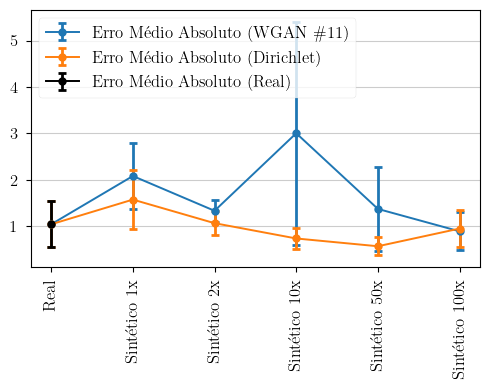

In [17]:
name = regressor_model_name.replace("#", "\#")
labels = [f"Real", *wgan_indices_dict.keys()]
x = np.arange(len(labels))

f, ax = plt.subplots(figsize=(5, 4))

wgan_mae = np.r_[
    [indices["mean_absolute_error"][:, model_id, :].mean(axis=1)], 
    np.array([i["mae"] for i in wgan_indices_dict.values()])
]
dirichlet_mae = np.r_[
    [indices["mean_absolute_error"][:, model_id].mean(axis=1)], 
    np.array([i["mae"] for i in dirichlet_indices_dict.values()])
]

wgan_y = wgan_mae.mean(axis=1)
wgan_y_err = (wgan_mae.std(axis=1) / np.sqrt(K_FOLDS - 1))

dirichlet_y = dirichlet_mae.mean(axis=1)
dirichlet_y_err = (dirichlet_mae.std(axis=1) / np.sqrt(K_FOLDS - 1))

ax.errorbar(x, wgan_y, wgan_y_err, label="Erro Médio Absoluto (WGAN \#11)", c="tab:blue", **errorbar_kwargs)
ax.errorbar(x, dirichlet_y, dirichlet_y_err, label="Erro Médio Absoluto (Dirichlet)", c="tab:orange", **errorbar_kwargs)
ax.errorbar([x[0]], [wgan_y[0]], [wgan_y_err[0]], label="Erro Médio Absoluto (Real)", c="black", **errorbar_kwargs)
ax.yaxis.grid()
# ax.set_ylim(top=4.0)
ax.set_xticks(x, labels, rotation=90, ha="center")
ax.legend(loc="upper left")

f.tight_layout()
plt.savefig(os.path.join("data", "images", f"mae_errorbar_plot_synthetic_{regressor_model_name}.png"), dpi=600)
plt.show()